# Training

In [1]:
import time

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

In [4]:
from src.starcattovae.training.data import Data

from src.starcattovae.nn.vae import VAE
from src.starcattovae.nn.cvae import CVAE
from src.starcattovae.nn.vae_cnn import VAECNN

In [5]:
from src.starcattovae.plotting import plot_loss
from src.starcattovae.plotting import plot_individual_loss
from src.starcattovae.plotting import plot_training_validation_loss
from src.starcattovae.plotting import plot_reconstruction
from src.starcattovae.plotting import plot_waveform_grid
from src.starcattovae.plotting import plot_latent_morphs
from src.starcattovae.plotting import plot_signal_distribution

In [6]:
manualSeed = 99
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # reproducibility

### Define Parameters

In [7]:
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

# model parameters
batch_size = 32
epochs = 512

x_length = 256
hidden_dim = 512
latent_dim = 128
num_channels = 1
lr = 1e-3

Using device: mps


## Load Training Data

In [8]:
np.random.seed(42)
indices = np.arange(1684) # this is the number of signals minus all the signals with beta_IC_b less than 0
np.random.shuffle(indices)
split_ratio = 0.9
split_idx = int(len(indices) * split_ratio)
train_indices = indices[:split_idx]
validation_indices = indices[split_idx:]

# Create train and validation datasets
train_dataset = Data(indices=train_indices, train=True)
validation_dataset = Data(indices=validation_indices, train=False)

# Check for overlap
train_indices_set = set(train_dataset.get_indices())
validation_indices_set = set(validation_dataset.get_indices())

overlap = train_indices_set.intersection(validation_indices_set)
if len(overlap) == 0:
    print("Train and validation sets are different.")
else:
    print("Train and validation sets have overlap.")

Train and validation sets are different.


In [9]:
train_dataset.summary()
validation_dataset.summary()

2024-11-24 00:00:39.788 | INFO     | src.starcattovae.training.data:summary:96 - Signal Dataset mean: -0.524 +/- 39.879
Signal Dataset scaling factor (to match noise in generator): 5
Signal Dataset max value: 656.2575073242188
Signal Dataset shape: (256, 1515)

2024-11-24 00:00:39.790 | INFO     | src.starcattovae.training.data:summary:96 - Signal Dataset mean: -0.444 +/- 38.309
Signal Dataset scaling factor (to match noise in generator): 5
Signal Dataset max value: 626.9296875
Signal Dataset shape: (256, 169)



In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

## Load VAE

In [11]:
model = VAE(input_dim=x_length, hidden_dim=hidden_dim, latent_dim=latent_dim, DEVICE=DEVICE).to(DEVICE)
model_conditional = CVAE(input_dim=x_length, hidden_dim=hidden_dim, latent_dim=latent_dim, condition_dim=1, DEVICE=DEVICE).to(DEVICE)

### Loss Function

In [12]:
def loss_function(x, x_hat, mean, log_var):
    # sse loss
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    reproduction_loss *= 1 * x.shape[1]
    
    # KL Divergence loss
    kld_loss = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    # total loss
    total_loss = reproduction_loss + kld_loss

    return total_loss, reproduction_loss, kld_loss

optimizer = Adam(model.parameters(), lr=lr)

### Train VAE

In [13]:
print("Start training VAE...")
avg_total_losses = []
avg_reproduction_losses = []
avg_kld_losses = []

avg_total_losses_validation = []
avg_reproduction_losses_validation = []
avg_kld_losses_validation = []

noise = torch.randn(batch_size, latent_dim).to(DEVICE)

# validation data for validation
validation_data = []
for x_validation, y_validation in validation_dataloader:
    validation_data.append(x_validation.to(DEVICE))
validation_data = torch.cat(validation_data, dim=0)

for epoch in tqdm(range(epochs), desc="Training"):
    overall_total_loss = 0
    overall_reproduction_loss = 0
    overall_kld_loss = 0

    overall_total_loss_validation = 0
    overall_reproduction_loss_validation = 0
    overall_kld_loss_validation = 0

    total_samples = 0

    for batch_idx, (x, y) in enumerate(train_dataloader, 0):
        model.train()
        x = x.view(x.size(0), -1)  # Reshape to (batch_size, 256) if needed
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        total_loss, reproduction_loss, KLD = loss_function(x, x_hat, mean, log_var)
        
        overall_total_loss += total_loss.item()
        overall_reproduction_loss += reproduction_loss.item()
        overall_kld_loss += KLD.item()
        total_samples += x.size(0)

        total_loss.backward()
        optimizer.step()

        # validation losses
        model.eval()
        with torch.no_grad():
            x_validation = validation_data
            x_validation = x_validation.view(x_validation.size(0), -1).to(DEVICE)
            x_hat_validation, mean_validation, log_var_validation = model(x_validation)
            total_loss_validation, reproduction_loss_validation, kld_loss_validation = loss_function(x_validation, x_hat_validation, mean_validation, log_var_validation)

    # summarise training losses
    avg_total_loss = overall_total_loss / total_samples
    avg_reproduction_loss = overall_reproduction_loss / total_samples
    avg_kld_loss = overall_kld_loss / total_samples

    avg_total_losses.append(avg_total_loss)
    avg_reproduction_losses.append(avg_reproduction_loss)
    avg_kld_losses.append(avg_kld_loss)

    # summarise validation losses
    avg_total_loss_validation = total_loss_validation.item() / x_validation.size(0)
    avg_reproduction_loss_validation = reproduction_loss_validation.item() / x_validation.size(0)
    avg_kld_loss_validation = kld_loss_validation.item() / x_validation.size(0)

    avg_total_losses_validation.append(avg_total_loss_validation)
    avg_reproduction_losses_validation.append(avg_reproduction_loss_validation)
    avg_kld_losses_validation.append(avg_kld_loss_validation)

    tqdm.write(f'Epoch {epoch+1}, Train Loss: {avg_total_loss:.4f}, Val Loss: {avg_total_loss_validation:.4f}')

    if (epoch + 1) % 10 == 0:
        x = x.cpu().detach()
        x_hat = x_hat.cpu().detach()
        plot_reconstruction(x[0], x_hat[0], max_value=train_dataset.max_value)

        with torch.no_grad():
            generated_signals = model.decoder(noise).cpu().detach().numpy()
        
        plot_waveform_grid(signals=generated_signals, max_value=train_dataset.max_value)

        idx1 = torch.randint(0, x.size(0), (1,)).item()
        idx2 = idx1

        while idx2 == idx1: # ensures we don't sample the same signal
            idx2 = torch.randint(0, x.size(0), (1,)).item()

        signal_1 = x[idx1].to(DEVICE)
        signal_2 = x[idx2].to(DEVICE)
        
        plot_latent_morphs(model, signal_1, signal_2, max_value=train_dataset.max_value, steps=8)

print("Training finished!")
model.eval()

Start training VAE...


Training:   0%|          | 1/512 [00:01<09:05,  1.07s/it]

Epoch 1, Train Loss: 230.3114, Val Loss: 144.0662


Training:   0%|          | 2/512 [00:01<07:05,  1.20it/s]

Epoch 2, Train Loss: 121.7092, Val Loss: 113.2195


Training:   1%|          | 3/512 [00:02<06:26,  1.32it/s]

Epoch 3, Train Loss: 95.6863, Val Loss: 92.1212


Training:   1%|          | 4/512 [00:03<06:17,  1.35it/s]

Epoch 4, Train Loss: 85.4582, Val Loss: 87.3406


Training:   1%|          | 4/512 [00:03<07:34,  1.12it/s]


KeyboardInterrupt: 

Start training CVAE...


Training:   0%|          | 1/512 [00:00<03:36,  2.36it/s]

Epoch 1, Train Loss: 949.1920, Val Loss: 944.5099


Training:   0%|          | 2/512 [00:00<03:26,  2.47it/s]

Epoch 2, Train Loss: 954.6330, Val Loss: 938.0551


Training:   1%|          | 3/512 [00:01<03:21,  2.52it/s]

Epoch 3, Train Loss: 946.7393, Val Loss: 947.4220


Training:   1%|          | 4/512 [00:01<03:17,  2.57it/s]

Epoch 4, Train Loss: 948.2683, Val Loss: 957.4275


Training:   1%|          | 5/512 [00:02<03:24,  2.47it/s]

Epoch 5, Train Loss: 953.4057, Val Loss: 958.1520


Training:   1%|          | 6/512 [00:02<03:21,  2.51it/s]

Epoch 6, Train Loss: 948.3429, Val Loss: 933.9708


Training:   1%|▏         | 7/512 [00:02<03:19,  2.54it/s]

Epoch 7, Train Loss: 948.7748, Val Loss: 950.6784


Training:   2%|▏         | 8/512 [00:03<03:18,  2.54it/s]

Epoch 8, Train Loss: 949.2043, Val Loss: 952.9551


Training:   2%|▏         | 9/512 [00:03<03:18,  2.54it/s]

Epoch 9, Train Loss: 950.6268, Val Loss: 949.5760


Training:   2%|▏         | 9/512 [00:03<03:18,  2.54it/s]

Epoch 10, Train Loss: 945.9080, Val Loss: 941.3968


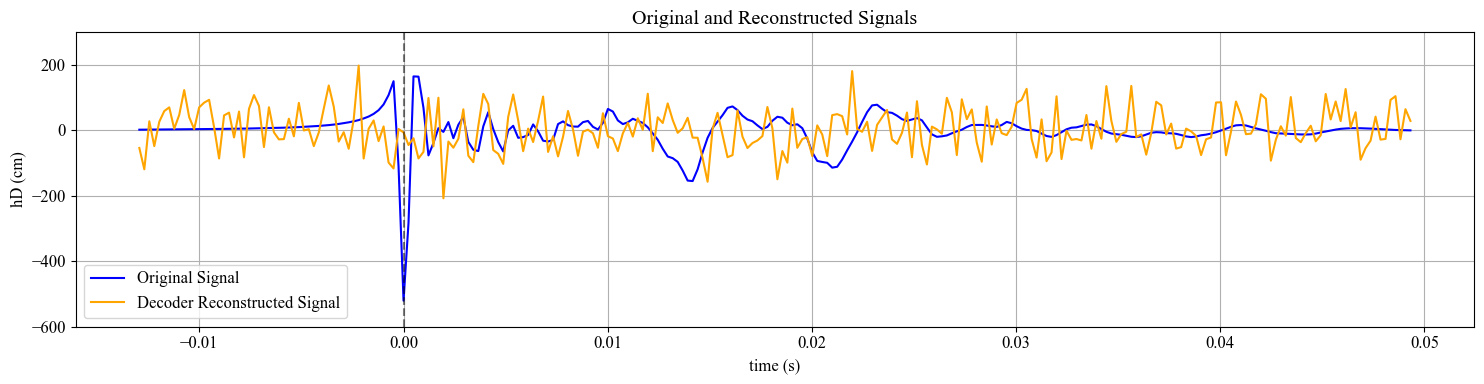

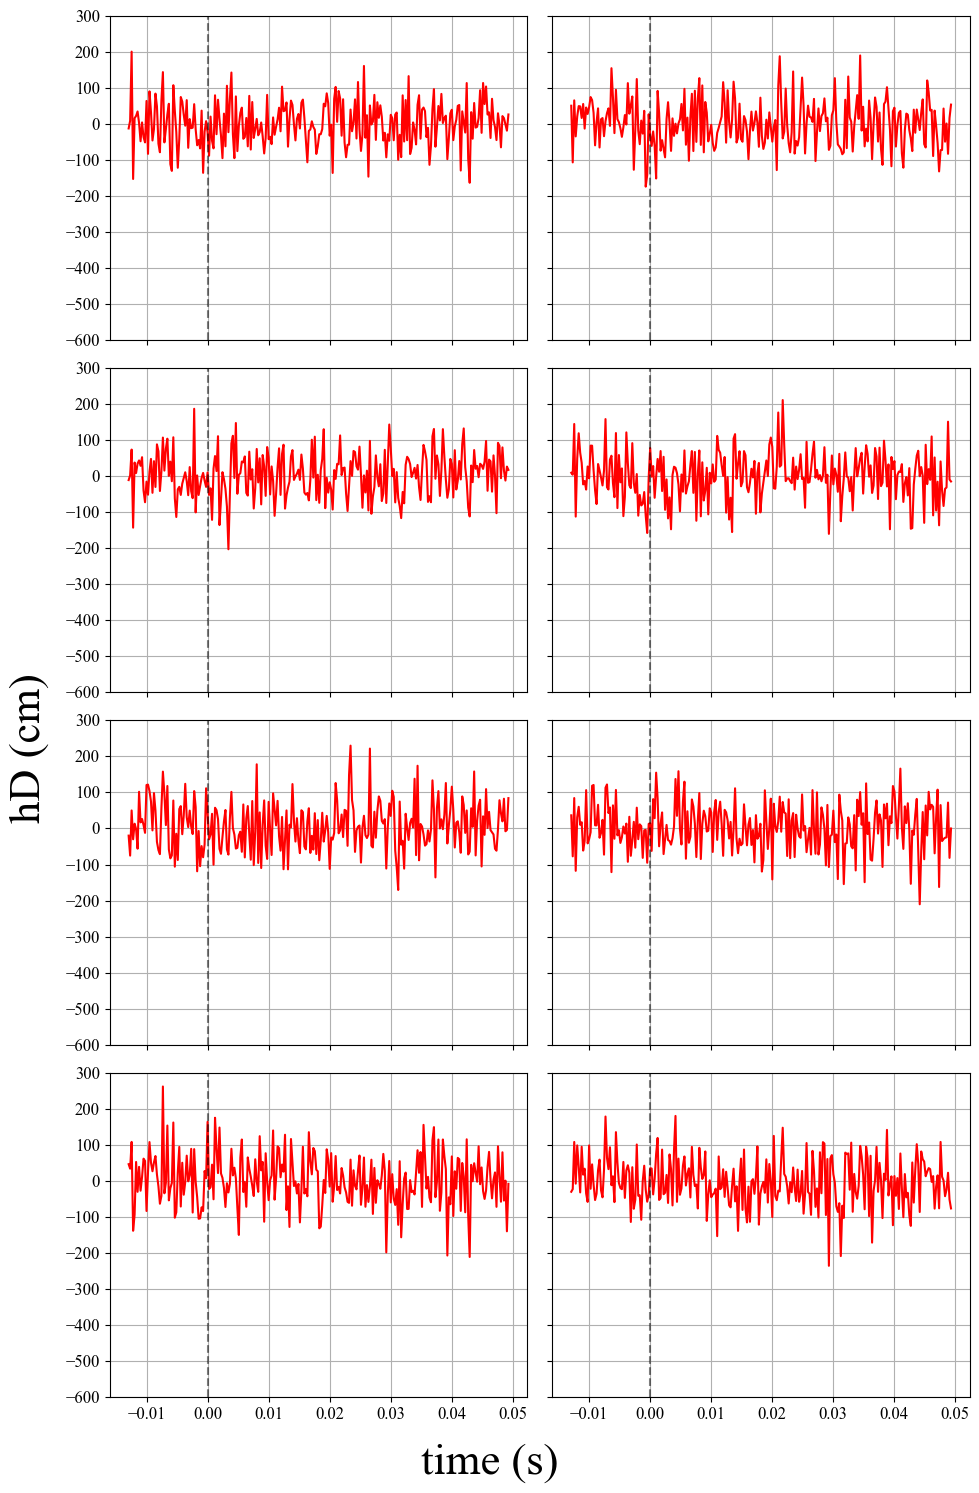

Training:   2%|▏         | 9/512 [00:04<04:17,  1.95it/s]


TypeError: forward() missing 1 required positional argument: 'condition'

In [ ]:
print("Start training CVAE...")
avg_total_losses = []
avg_reproduction_losses = []
avg_kld_losses = []

avg_total_losses_validation = []
avg_reproduction_losses_validation = []
avg_kld_losses_validation = []

noise = torch.randn(batch_size, latent_dim).to(DEVICE)
condition_noise = torch.tensor([0.1] * batch_size, dtype=torch.float32).to(DEVICE).unsqueeze(1)

# validation data for validation
validation_data = []
validation_conditions = []
for x_validation, y_validation in validation_dataloader:
    validation_data.append(x_validation.to(torch.float32).to(DEVICE))
    validation_conditions.append(y_validation.to(torch.float32).to(DEVICE).unsqueeze(1))
validation_data = torch.cat(validation_data, dim=0)
validation_conditions = torch.cat(validation_conditions, dim=0)

for epoch in tqdm(range(epochs), desc="Training"):
    overall_total_loss = 0
    overall_reproduction_loss = 0
    overall_kld_loss = 0

    overall_total_loss_validation = 0
    overall_reproduction_loss_validation = 0
    overall_kld_loss_validation = 0

    total_samples = 0

    for batch_idx, (x, y) in enumerate(train_dataloader, 0):
        model_conditional.train()
        x = x.view(x.size(0), -1)  # Reshape to (batch_size, 256) if needed
        x = x.to(DEVICE)
        y = y.to(torch.float32).to(DEVICE).unsqueeze(1)

        optimizer.zero_grad()

        x_hat, mean, log_var = model_conditional(x, y)
        total_loss, reproduction_loss, KLD = loss_function(x, x_hat, mean, log_var)
        
        overall_total_loss += total_loss.item()
        overall_reproduction_loss += reproduction_loss.item()
        overall_kld_loss += KLD.item()
        total_samples += x.size(0)

        total_loss.backward()
        optimizer.step()

        # validation losses
        model_conditional.eval()
        with torch.no_grad():
            x_validation = validation_data
            y_validation = validation_conditions
            x_validation = x_validation.view(x_validation.size(0), -1).to(DEVICE)
            x_hat_validation, mean_validation, log_var_validation = model_conditional(x_validation, y_validation)
            total_loss_validation, reproduction_loss_validation, kld_loss_validation = loss_function(x_validation, x_hat_validation, mean_validation, log_var_validation)

    # summarise training losses
    avg_total_loss = overall_total_loss / total_samples
    avg_reproduction_loss = overall_reproduction_loss / total_samples
    avg_kld_loss = overall_kld_loss / total_samples

    avg_total_losses.append(avg_total_loss)
    avg_reproduction_losses.append(avg_reproduction_loss)
    avg_kld_losses.append(avg_kld_loss)

    # summarise validation losses
    avg_total_loss_validation = total_loss_validation.item() / x_validation.size(0)
    avg_reproduction_loss_validation = reproduction_loss_validation.item() / x_validation.size(0)
    avg_kld_loss_validation = kld_loss_validation.item() / x_validation.size(0)

    avg_total_losses_validation.append(avg_total_loss_validation)
    avg_reproduction_losses_validation.append(avg_reproduction_loss_validation)
    avg_kld_losses_validation.append(avg_kld_loss_validation)

    tqdm.write(f'Epoch {epoch+1}, Train Loss: {avg_total_loss:.4f}, Val Loss: {avg_total_loss_validation:.4f}')

    if (epoch + 1) % 10 == 0:
        x = x.cpu().detach()
        x_hat = x_hat.cpu().detach()
        plot_reconstruction(x[0], x_hat[0], max_value=train_dataset.max_value)

        with torch.no_grad():
            generated_signals = model_conditional.decoder(noise, condition_noise).cpu().detach().numpy()
        
        plot_waveform_grid(signals=generated_signals, max_value=train_dataset.max_value)

        idx1 = torch.randint(0, x.size(0), (1,)).item()
        idx2 = idx1

        while idx2 == idx1: # ensures we don't sample the same signal
            idx2 = torch.randint(0, x.size(0), (1,)).item()

        signal_1 = x[idx1].to(DEVICE)
        signal_2 = x[idx2].to(DEVICE)
        condition_1 = y[idx1].to(DEVICE)
        condition_2 = y[idx2].to(DEVICE)
        
        # plot_latent_morphs(model_conditional, signal_1, signal_2, max_value=train_dataset.max_value, steps=8)

print("Training finished!")
model_conditional.eval()

### Training and Validation Loss

In [ ]:
plot_training_validation_loss(avg_total_losses, avg_total_losses_validation)

In [ ]:
plot_individual_loss(avg_total_losses, avg_reproduction_losses, avg_kld_losses)

### Generated XXXXX Signals

In [ ]:
number_of_signals = 10000
noise = torch.randn(number_of_signals, latent_dim).to(DEVICE)

start_time = time.time()
with torch.no_grad():
    generated_signals = model.decoder(noise).cpu().detach().numpy()
end_time = time.time()

execution_time = end_time - start_time
print("Execution Time:", execution_time, "seconds")

In [ ]:
generated_signals_transpose = np.empty((x_length, 0))

for i in range(number_of_signals):
    y = generated_signals[i, :].flatten()
    y = y * train_dataset.max_value
    y = y.reshape(-1, 1)
    
    generated_signals_transpose = np.concatenate((generated_signals_transpose, y), axis=1)

### Plot Generated Distribution

In [ ]:
plot_signal_distribution(generated_signals_transpose, generated=True)

### Morph Animation

In [ ]:
def animate_latent_morphs(
    model: VAE, 
    signal_1: torch.Tensor,
    signal_2: torch.Tensor,
    max_value: float, 
    steps=10,
    interval=200,
    save_path=None
):
    model.eval()

    with torch.no_grad():
        mean_1, _ = model.encoder(signal_1)
        mean_2, _ = model.encoder(signal_2)

        interpolated_latents = [mean_1 * (1 - alpha) + mean_2 * alpha for alpha in np.linspace(0, 1, steps)]
        morphed_signals = [model.decoder(latent).cpu().detach().numpy() for latent in interpolated_latents]

    fig, ax = plt.subplots(figsize=(10, 5))

    # X-axis values (shared across all plots)
    x_vals = [i / 4096 for i in range(0, 256)]
    x_vals = [value - (53 / 4096) for value in x_vals]

    # Initialize the plot
    line, = ax.plot([], [], color="red")
    ax.set_xlim(min(x_vals), max(x_vals))
    ax.set_ylim(-600, 300)
    ax.axvline(x=0, color="black", linestyle="--", alpha=0.5)
    ax.grid(True)
    ax.set_xlabel('time (s)', fontsize=16)
    ax.set_ylabel('hD (cm)', fontsize=16)

    def init():
        line.set_data([], [])
        return line,

    def update(frame):
        y_interp = morphed_signals[frame].flatten() * max_value
        line.set_data(x_vals, y_interp)
        ax.set_title(f"Interpolated Signal {frame + 1}")
        return line,

    ani = animation.FuncAnimation(fig, update, frames=range(steps), init_func=init, blit=True, interval=interval)

    if save_path:
        ani.save(save_path, writer='imagemagick', fps=30)

    plt.show()

# Example usage
animate_latent_morphs(model, signal_1, signal_2, train_dataset.max_value, steps=100, interval=200, save_path="morph_animation.gif")

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

def animate_latent_morphs(
    model,  # Assuming model is a VAE instance
    signal_1: torch.Tensor,
    signal_2: torch.Tensor,
    max_value: float, 
    train_dataset,
    steps=10,
    interval=200,
    save_path=None
):
    model.eval()

    with torch.no_grad():
        mean_1, _ = model.encoder(signal_1)
        mean_2, _ = model.encoder(signal_2)

        # Forward and backward interpolation
        forward_interpolated = [mean_1 * (1 - alpha) + mean_2 * alpha for alpha in np.linspace(0, 1, steps)]
        backward_interpolated = [mean_2 * (1 - alpha) + mean_1 * alpha for alpha in np.linspace(0, 1, steps)]
        interpolated_latents = forward_interpolated + backward_interpolated
        morphed_signals = [model.decoder(latent).cpu().detach().numpy() for latent in interpolated_latents]

        # Compute the posterior distribution
        all_means = []
        for data in train_dataset:
            data = torch.tensor(data).to(model.DEVICE)
            mean, _ = model.encoder(data)
            all_means.append(mean.cpu().numpy())
        all_means = np.concatenate(all_means, axis=0)

    fig = plt.figure(figsize=(10, 17))  # Adjust the figure size for vertical stacking

    # Create 3D plot for latent space
    ax_latent = fig.add_subplot(211, projection='3d')  # First plot (top) in vertical layout
    ax_latent.scatter(all_means[:, 0], all_means[:, 1], all_means[:, 2], color='gray', alpha=0.2, label='Posterior Distribution')
    ax_latent.scatter(mean_1[0].cpu().numpy(), mean_1[1].cpu().numpy(), mean_1[2].cpu().numpy(), color='blue', s=50, label='Signal 1')
    ax_latent.scatter(mean_2[0].cpu().numpy(), mean_2[1].cpu().numpy(), mean_2[2].cpu().numpy(), color='green', s=50, label='Signal 2')
    ax_latent.plot([mean_1[0].cpu().numpy(), mean_2[0].cpu().numpy()],
                   [mean_1[1].cpu().numpy(), mean_2[1].cpu().numpy()],
                   [mean_1[2].cpu().numpy(), mean_2[2].cpu().numpy()], color='red', linestyle='--', label='Interpolation Path', linewidth=2)
    moving_point, = ax_latent.plot([], [], [], 'ro', markersize=7, label='Interpolated Point')
    # ax_latent.set_title('Latent Space Interpolation')
    ax_latent.set_xlabel('Latent Dim 1')
    ax_latent.set_ylabel('Latent Dim 2')
    ax_latent.set_zlabel('Latent Dim 3')
    # ax_latent.legend()

    # Create plot for signal morphing
    ax_signal = fig.add_subplot(212)  # Second plot (bottom) in vertical layout

    # X-axis values (shared across all plots)
    x_vals = [i / 4096 for i in range(0, 256)]
    x_vals = [value - (53 / 4096) for value in x_vals]

    # Initialize the plot
    line, = ax_signal.plot([], [], color="red")
    ax_signal.set_xlim(min(x_vals), max(x_vals))
    ax_signal.set_ylim(-600, 300)
    ax_signal.axvline(x=0, color="black", linestyle="--", alpha=0.5)
    ax_signal.grid(True)
    ax_signal.set_xlabel('time (s)', fontsize=16)
    ax_signal.set_ylabel('hD (cm)', fontsize=16)

    def init():
        line.set_data([], [])
        moving_point.set_data([], [])
        moving_point.set_3d_properties([])
        return line, moving_point

    def update(frame):
        y_interp = morphed_signals[frame].flatten() * max_value
        line.set_data(x_vals, y_interp)
        # ax_signal.set_title(f"Interpolated Signal {frame + 1}")

        # Update the moving point in the latent space
        latent_point = interpolated_latents[frame].cpu().numpy()
        moving_point.set_data(latent_point[0], latent_point[1])
        moving_point.set_3d_properties(latent_point[2])
        return line, moving_point

    ani = animation.FuncAnimation(fig, update, frames=len(interpolated_latents), init_func=init, blit=True, interval=interval, repeat=True)

    if save_path:
        ani.save(save_path, writer='imagemagick', fps=30)

    plt.show()

# Example usage
animate_latent_morphs(model, signal_1, signal_2, train_dataset.max_value, train_dataset, steps=100, interval=200, save_path="morph_animation.gif")
